## Necessary Imports

In [3]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np 
import pandas as pd # read csv
import matplotlib.pyplot as plt  # plotting
from matplotlib import style

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import FashionMNIST, EMNIST
from torchvision.transforms import ToTensor, Normalize, Compose

import torch.nn as nn
from torchsummary import summary
from tqdm import tqdm
from torch import distributions


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Downloading dataset and forming data loaders

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import FashionMNIST, EMNIST
from torchvision.transforms import ToTensor, Normalize, Compose



transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
fdataset = FashionMNIST(root="./data", train=True, download=True, transform=transform)
train_data, test_data = torch.utils.data.random_split(fdataset,[50000, 10000])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=2)


# images, labels = next(iter(dataloader))
# print(f"{images.shape}= {labels.shape}=")

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## Visualization

torch.Size([64, 1, 28, 28])


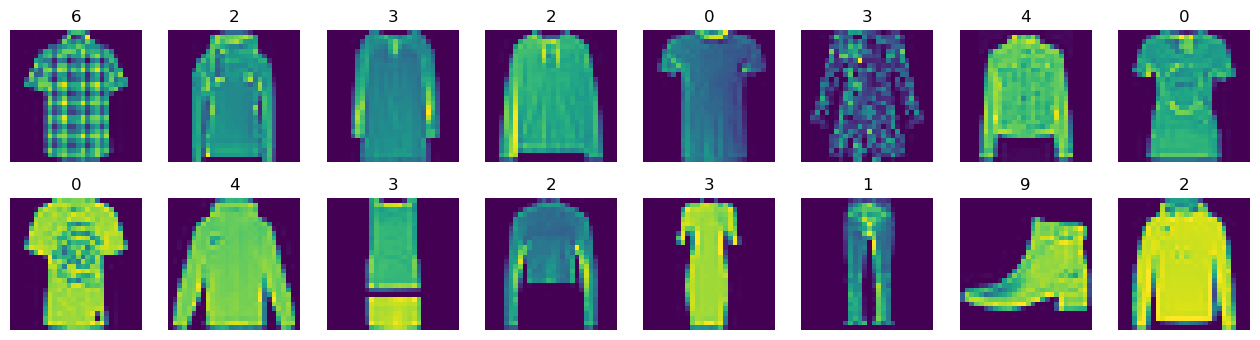

In [6]:
for idx, batch in enumerate(train_loader):
    print(batch[0].shape)
    figsize = plt.figure(figsize=(16,4))
    for i in range(16):
        plt.subplot(2,8,i+1)
        temp = batch[0][i].permute(1,2,0).numpy()
        plt.title(batch[1][i].item())
        plt.imshow(temp.reshape(28,28))
        plt.axis('off')
    plt.show()
    break

## Model, encoder and decoder classes

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(784,512)
        self.linear4 = nn.Linear(512,256)

        self.linear2 = nn.Linear(256,16) # this term is for calculating mu
        self.linear3 = nn.Linear(256,16) # this term is for calculating sigma
        self.dist = distributions.Normal(0,1)
        
        self.kl = 0
        
    def forward(self,x):
        op = nn.LeakyReLU(0.2)(self.linear1(x))
        op = nn.LeakyReLU(0.2)(self.linear4(op))
        mu = self.linear2(op)
        sigma = torch.exp(self.linear3(op)) 
        sample = self.dist.sample(mu.shape).to(device)
        z = mu + sigma*sample
        self.kl = (mu**2 + sigma**2 - torch.log(sigma) -1/2).sum()
        return z

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(16,256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,784),
            nn.Sigmoid()
        )

    def forward(self,x):
        op = self.model(x)
        return op

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)
        
        
    def forward(self,x):
        op = self.encoder(x)
        op = self.decoder(op)
        return op

In [10]:
model = Autoencoder().to(device)
summary(model, (784, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                  [-1, 256]         131,328
            Linear-3                   [-1, 16]           4,112
            Linear-4                   [-1, 16]           4,112
           Encoder-5                   [-1, 16]               0
            Linear-6                  [-1, 256]           4,352
         LeakyReLU-7                  [-1, 256]               0
            Linear-8                  [-1, 512]         131,584
         LeakyReLU-9                  [-1, 512]               0
           Linear-10                  [-1, 784]         402,192
          Sigmoid-11                  [-1, 784]               0
          Decoder-12                  [-1, 784]               0
Total params: 1,079,600
Trainable params: 1,079,600
Non-trainable params: 0
---------------------------

### Utils

In [11]:
def train(epoch, loader, model, optimizer, scaler, scheduler, device = device):
    model.train()
    losses = 0
    num_batches = len(loader)
    train_acc = 0
    batches = tqdm(loader) # tqdm will be used to generate progress bars
    
    for i, batch in enumerate(batches):
        inp = batch[0].reshape(-1, 784).to(device)
        
        
        # forward propagation
        
        with torch.cuda.amp.autocast(): # for gradient underflowing and overflowing and it makes training faster by converting all floats to float16
            pred = model(inp)
            loss = ((pred - inp)**2).sum() + model.encoder.kl
        
        
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
                                                
        batches.set_postfix(loss = loss.item(), epoch = epoch) # loss of this current batch on current iteration 
        losses+= loss.item() 
        
    losses/=num_batches   
#     scheduler.step()
    return losses

In [12]:
def save_checkpoint(state, filename='my_checkpoint.pth'):
    # will save model and optimizer params at every epoch
    print("-> Saving CheckPoint")
    torch.save(state, filename)

In [13]:
def load_checkpoint(checkpoint, model):
    # it will just load, we can train it further, make changes to the architecture
    # and simply use it to predict
    print("-> Loading CheckPoint")
    model.load_state_dict(checkpoint["state_dict"])

## for testing model over small sample

In [14]:
# this model's testing clearly depends upon how good the image visuals are
def test(model):
    model.eval()
    with torch.no_grad():
        fig = plt.figure(figsize=(16,4))
        for i in range(16):
            fig.add_subplot(2,8,i+1)
            noise = distributions.Normal(0,1).sample((1,16)).to(device)
            image = model.decoder(noise).reshape(28,28)
            image = image.cpu().detach().numpy()
            plt.imshow(image)
            plt.axis('off')
    plt.show()
    model.train()

## Driver Code

In [15]:
###### hparams
batch_size = 64
lr = 1e-3
num_epochs = 20

# setting up the data
# train_data = data.iloc[:, 1:].values
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)

# setting up the model, optimizer, scaler, scheduler
model = Autoencoder().to(device)
scaler = torch.cuda.amp.GradScaler() 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
losses = []

100%|██████████| 782/782 [00:15<00:00, 51.34it/s, loss=7.51e+3]


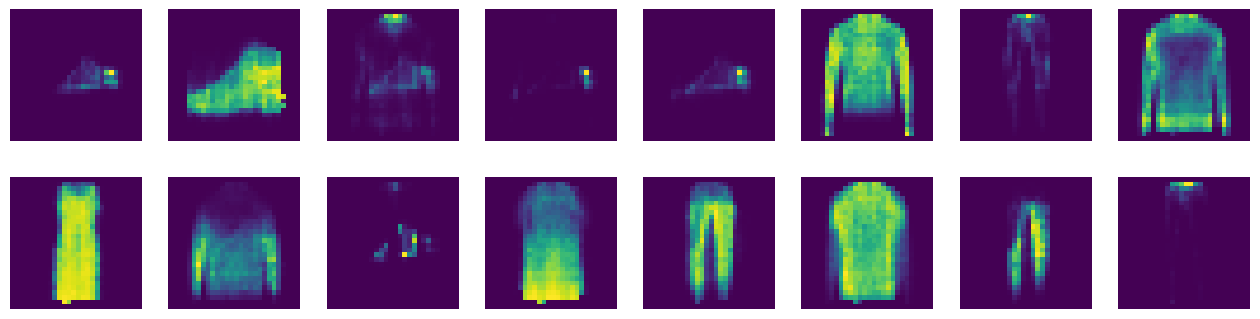

100%|██████████| 782/782 [00:14<00:00, 53.22it/s, loss=8.11e+3]


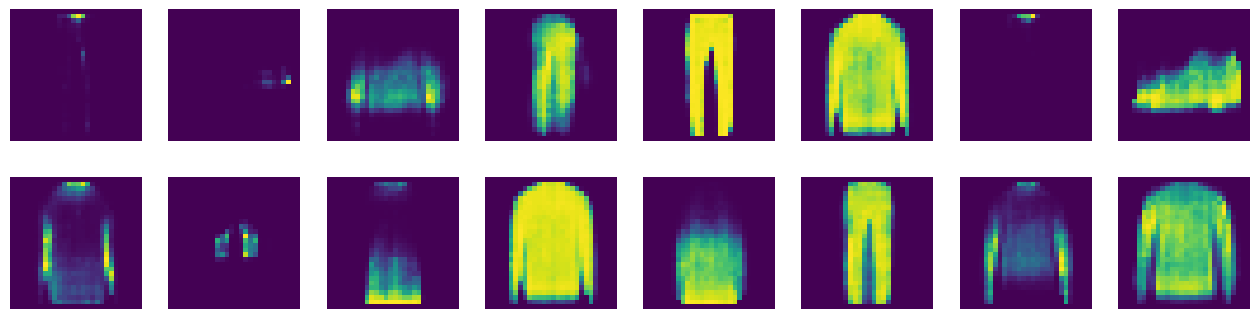

100%|██████████| 782/782 [00:15<00:00, 50.80it/s, loss=6.96e+3]


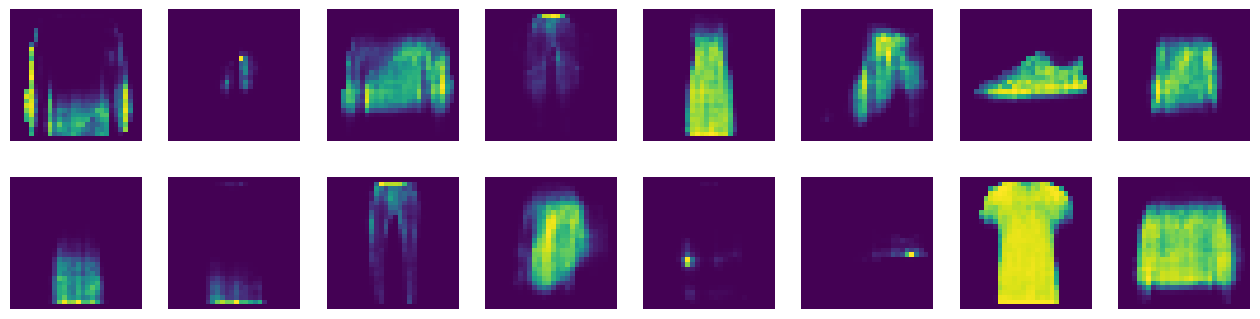

100%|██████████| 782/782 [00:14<00:00, 54.55it/s, loss=7.87e+3]


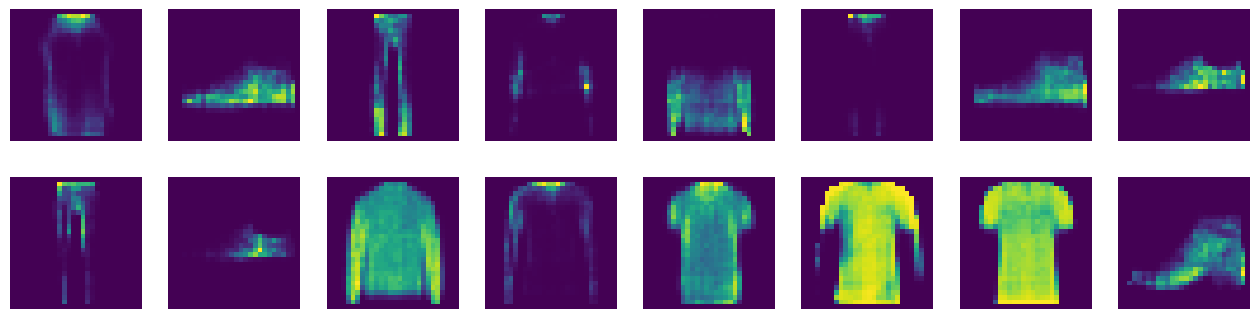

100%|██████████| 782/782 [00:15<00:00, 51.71it/s, loss=7.43e+3]


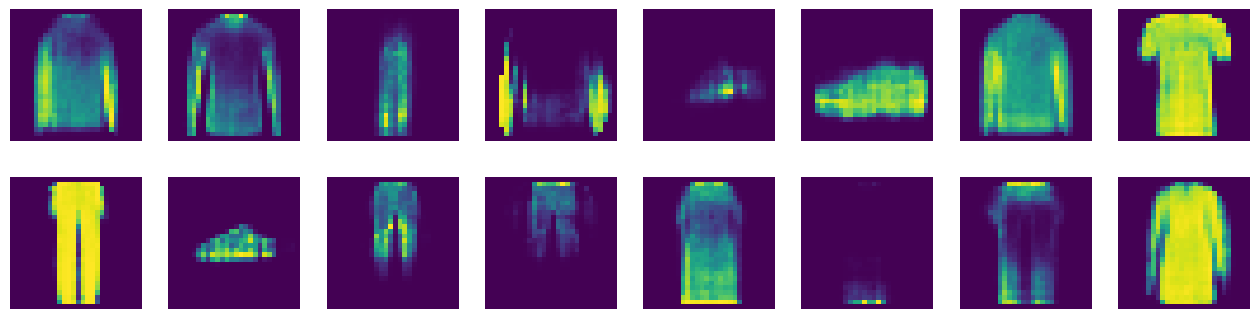

100%|██████████| 782/782 [00:14<00:00, 52.58it/s, loss=7.34e+3]


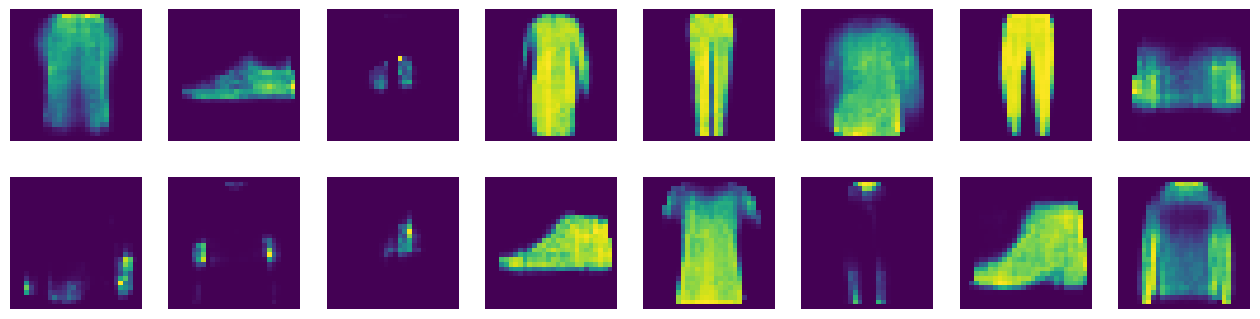

100%|██████████| 782/782 [00:15<00:00, 49.72it/s, loss=7.33e+3]


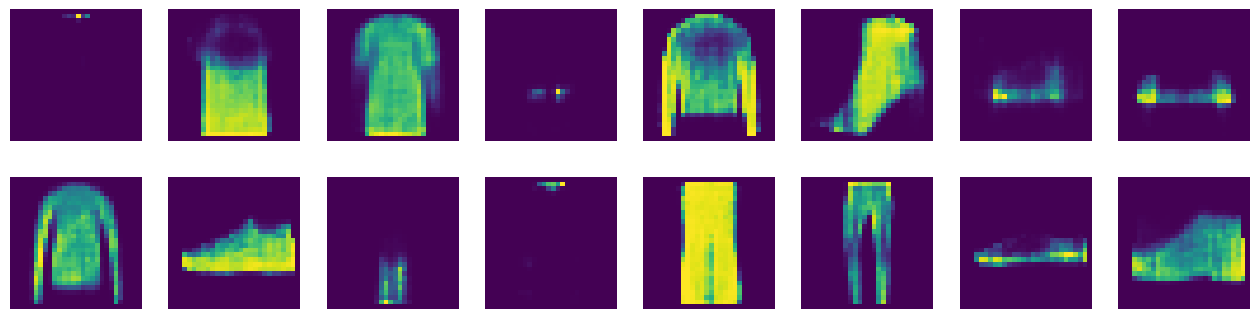

100%|██████████| 782/782 [00:14<00:00, 53.26it/s, loss=8.53e+3]


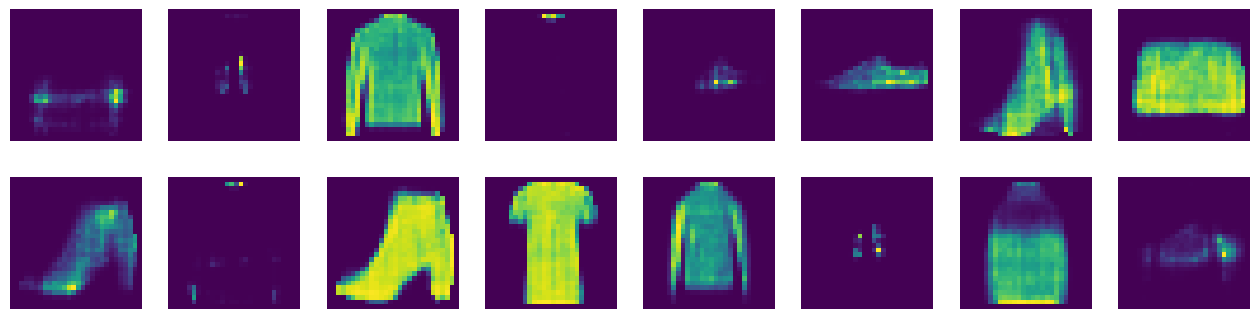

100%|██████████| 782/782 [00:15<00:00, 51.94it/s, loss=8.37e+3]


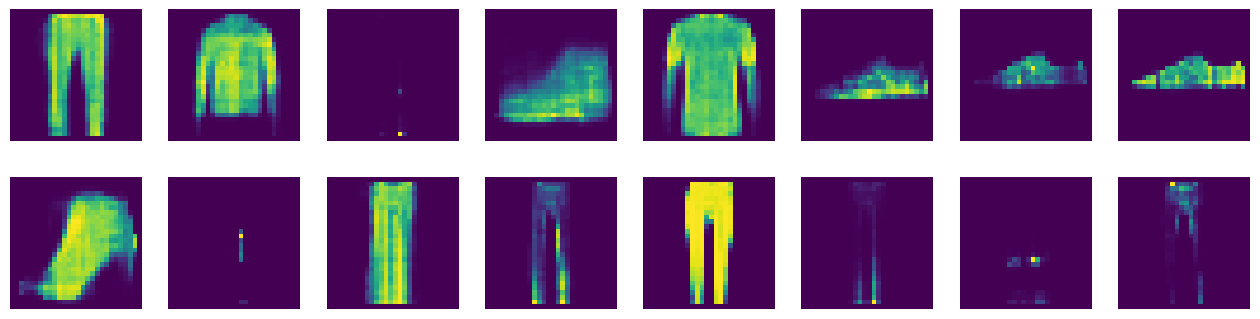

100%|██████████| 782/782 [00:14<00:00, 52.41it/s, loss=7.55e+3]


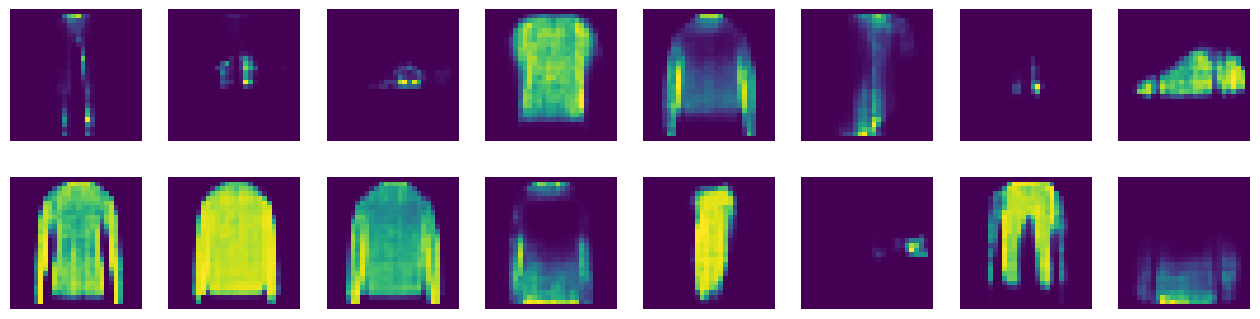

100%|██████████| 782/782 [00:14<00:00, 54.32it/s, loss=7.59e+3]


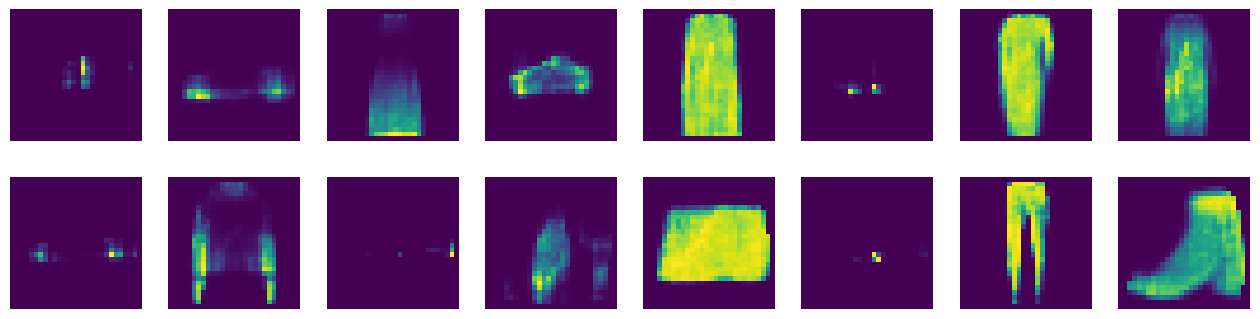

100%|██████████| 782/782 [00:15<00:00, 49.71it/s, loss=8.49e+3]


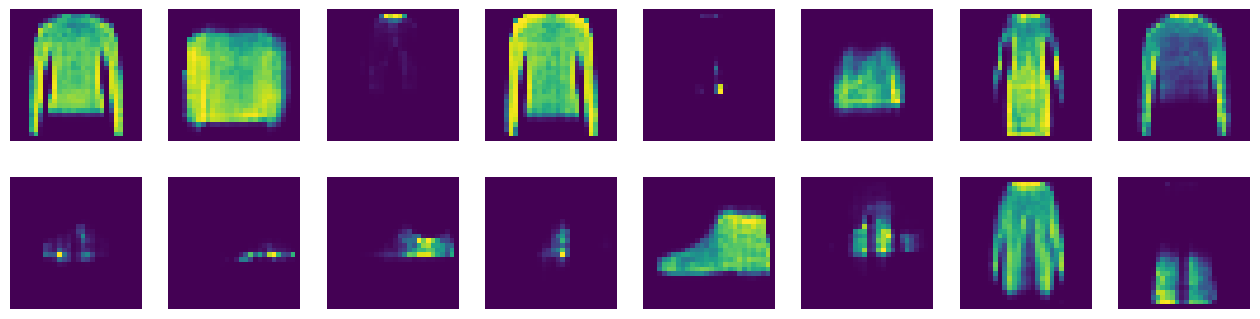

100%|██████████| 782/782 [00:14<00:00, 53.15it/s, loss=6.85e+3]


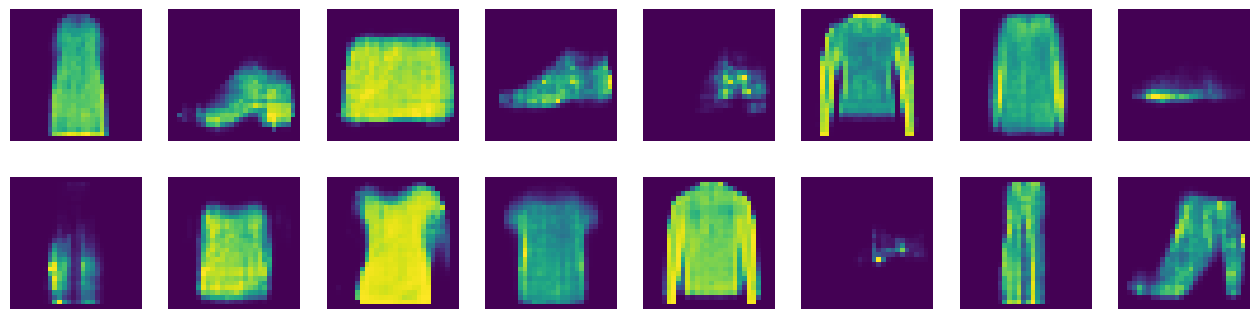

100%|██████████| 782/782 [00:15<00:00, 51.59it/s, loss=7.49e+3]


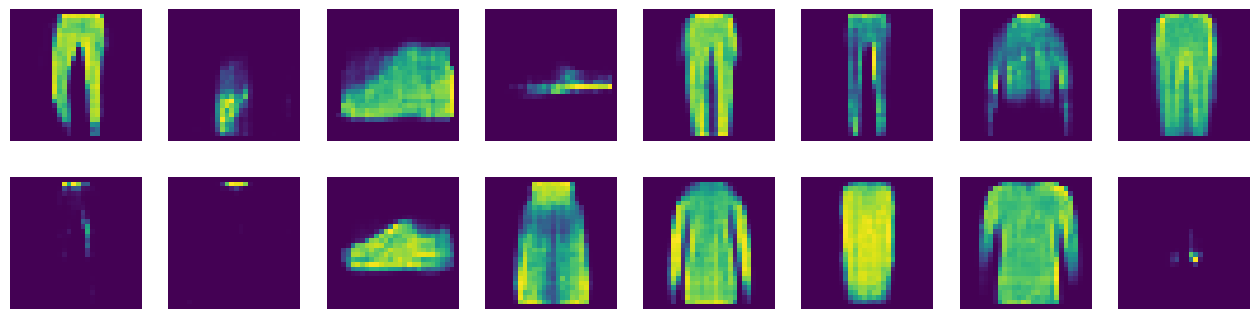

100%|██████████| 782/782 [00:14<00:00, 53.28it/s, loss=7.35e+3]


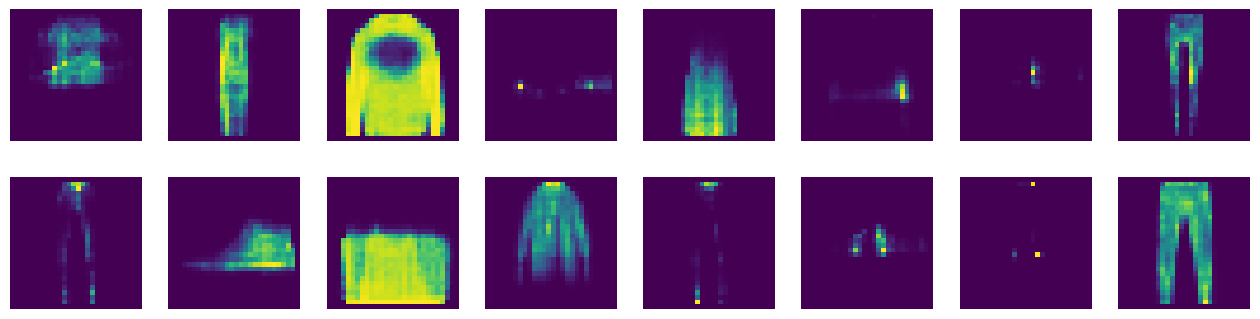

100%|██████████| 782/782 [00:15<00:00, 50.83it/s, loss=7.56e+3]


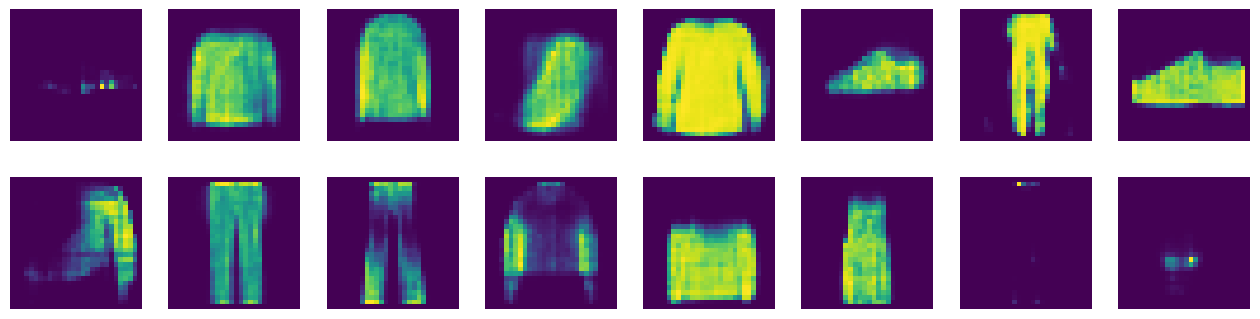

100%|██████████| 782/782 [00:15<00:00, 52.02it/s, loss=7.42e+3]


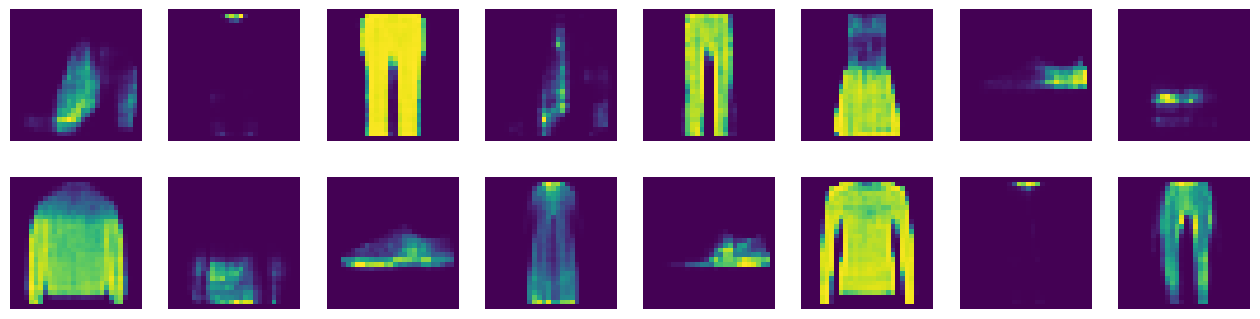

100%|██████████| 782/782 [00:15<00:00, 51.34it/s, loss=7.95e+3]


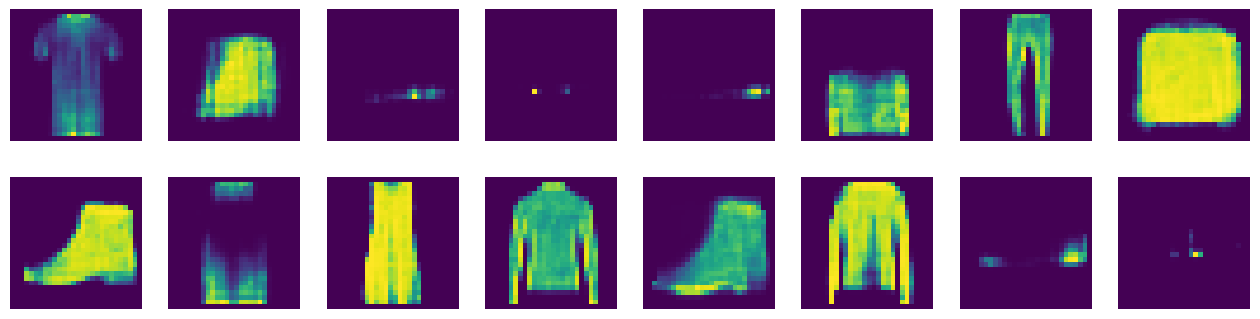

100%|██████████| 782/782 [00:14<00:00, 54.71it/s, loss=8.23e+3]


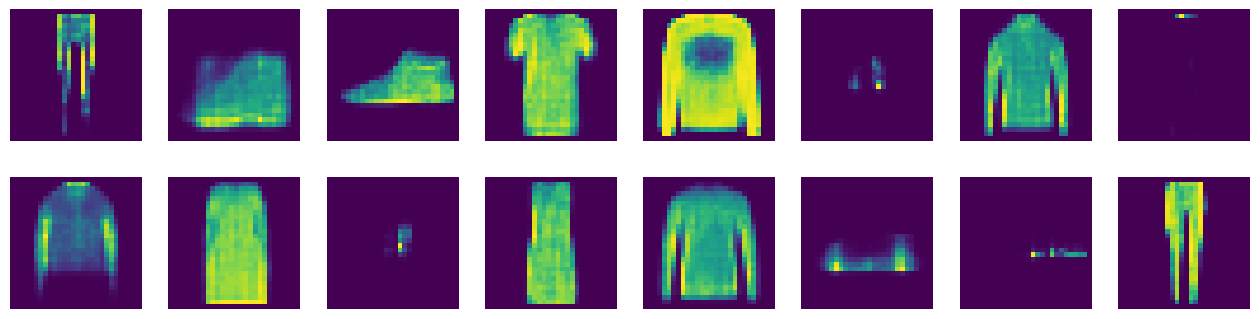

100%|██████████| 782/782 [00:15<00:00, 51.21it/s, loss=7.49e+3]


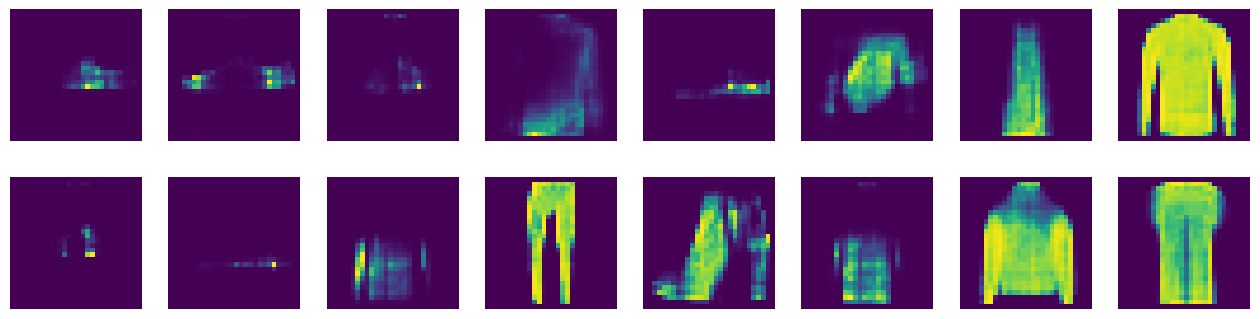

In [16]:
for epoch in range(num_epochs):
    model.train()
    losses.append(train(epoch, train_loader, model, optimizer, scaler,scheduler))
    
    # save checkpoints 
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer':optimizer.state_dict()
    }
#     save_checkpoint(checkpoint)
    # check accuracy  om test set
    test(model)

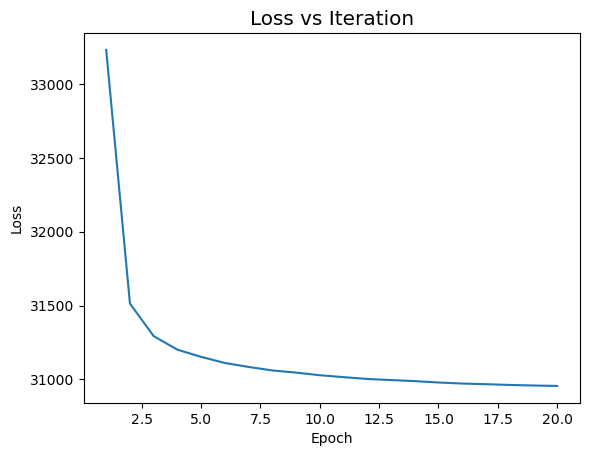

In [17]:
plt.plot(range(1, num_epochs+1), losses)
style.use('ggplot')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.show()

# Inferences
### - Firstly, visualizing the clusters formed using TSNE on Test Data
### - Then, checking for disentanglement of latent space by taking a random image from test set and encoding it into latent dim(16), then, adding a Guassian noise to each dim one by one and visualizing the changes that occur due to introduction of noise by decoding the noised vector and plotting the noised image.


In [27]:
# Collecting the encodings of 100 batches from test data to visualize it through T-SNE
model.eval()
lst = []
labels = []
num_batches = 0
for idx, batch in enumerate(test_loader):
    
    inp = batch[0].reshape(-1, 784).to(device)
    tar = batch[1]
    
    op = model.encoder(inp)
    op = op.to('cpu').detach().numpy()
    tar = tar.numpy()
    labels.append(tar)
    # op->64x10
    lst.append(op)
    if num_batches>=100:
        break
    else:
        num_batches += 1

In [28]:
lst = np.array(lst)
lst = lst.reshape((lst.shape[0]*64, 16))
labels =  np.array(labels)
labels = labels.reshape((labels.shape[0]*64))

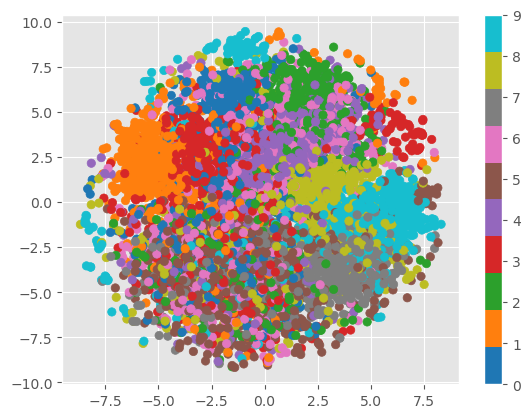

In [29]:
# we have set perplexity to 200 as this was performing better compared to lower perplexity in segregating the clusters

vis_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=200).fit_transform(lst)
plt.scatter(vis_embedded[:, 0], vis_embedded[:, 1], c=labels, cmap='tab10')
plt.colorbar()
plt.show()

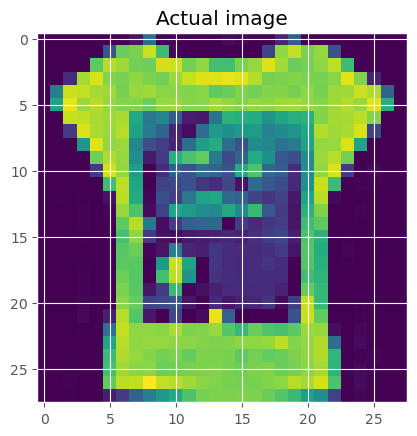

In [32]:
op = 0
for i, batch in enumerate(test_loader):
    plt.imshow(batch[0][0].reshape(28, 28).numpy())
    plt.title("Actual image")
    plt.show()
    inp = batch[0][0].reshape(1, 784).to(device)
    op = model.encoder(inp)
    
    break 

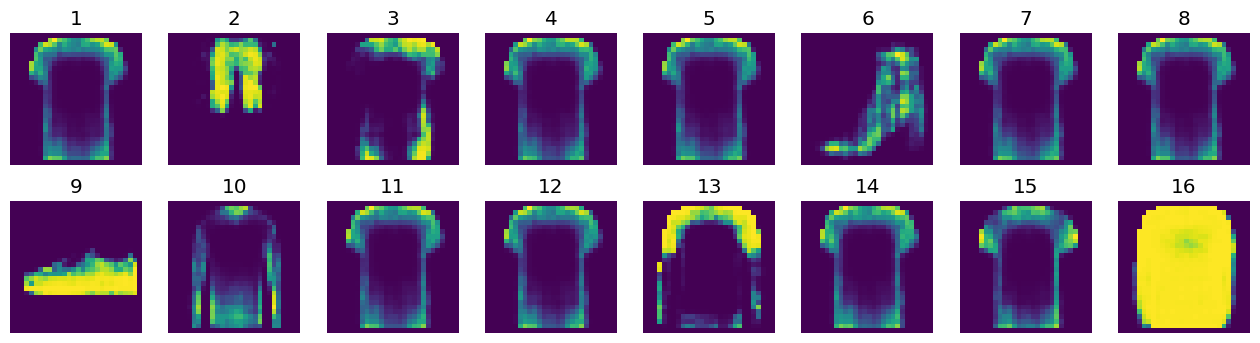

In [36]:
noise = torch.randn(1)*10
figure = plt.figure(figsize=(16, 4))
# title of image means the i+1 th dimension that has been noised
for i in range(16):
    op[0][i]+=noise[0]
    de = model.decoder(op).reshape(28,28)
    de = de.cpu().detach().numpy()
    op[0][i] -= noise[0]
    plt.subplot(2, 8, i+1)
    plt.imshow(de)
    plt.title(f"{i+1}")
    plt.axis('off')
plt.show()
    
    

### In the generated output, we can see that on adding noise to 2nd, 6th ,9th, 10th and 16th element of latent vector of actual encoded image (Short Sleeve T-Shirt) generated different outputs.

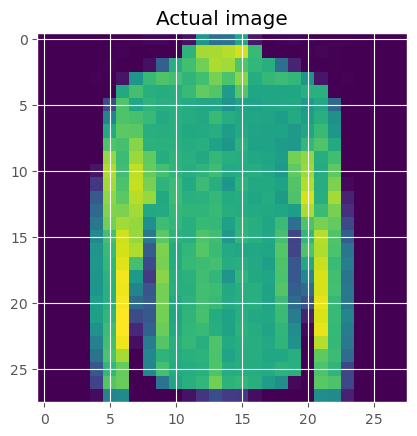

In [46]:
# checking the same for another image
op = 0
for i, batch in enumerate(test_loader):
    plt.imshow(batch[0][0].reshape(28, 28).numpy())
    plt.title("Actual image")
    plt.show()
    inp = batch[0][0].reshape(1, 784).to(device)
    op = model.encoder(inp)
    
    break 

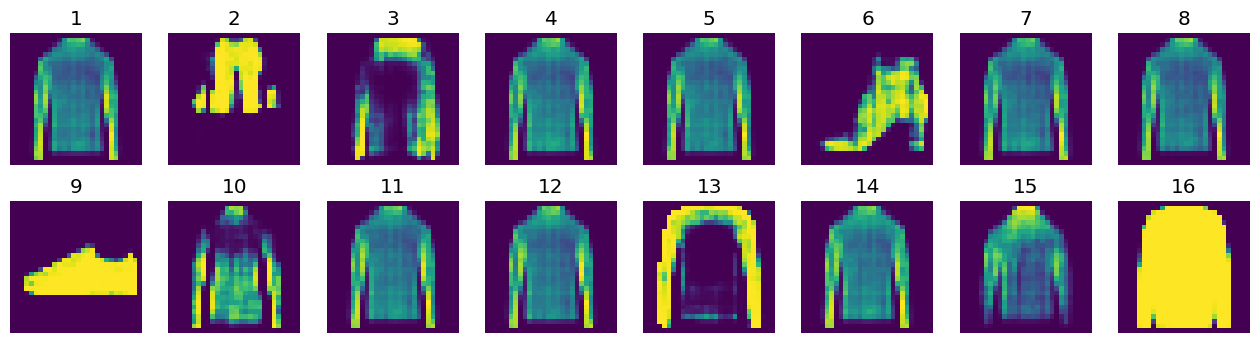

In [47]:
noise = torch.randn(1)*10
figure = plt.figure(figsize=(16, 4))
# title of image means the i+1 th dimension that has been noised
for i in range(16):
    op[0][i]+=noise[0]
    de = model.decoder(op).reshape(28,28)
    de = de.cpu().detach().numpy()
    op[0][i] -= noise[0]
    plt.subplot(2, 8, i+1)
    plt.imshow(de)
    plt.title(f"{i+1}")
    plt.axis('off')
plt.show()
    
    